In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from functions import *

In [2]:
ladd_anotation_path = '../../../ladd-and-weights/dataset/full_train_ds/Annotations/'
ipsar_anotation_path = '../../../ladd-and-weights/dataset/3rd_party/heridal/Annotations/'


In [3]:
data = []
for xml_name in os.listdir(ladd_anotation_path):
    if not os.path.isfile(os.path.join(ladd_anotation_path,xml_name)):
        continue
    file_id,_ = os.path.splitext(xml_name)
    img_size, points_yxyx=get_imgSize_and_list_of_yxyx(os.path.join(ladd_anotation_path,xml_name))
    xywhs=[get_xywh_from_point(img_size,xyxy_single,file_id) for xyxy_single in points_yxyx]
    data.extend(xywhs)
ladd_coords = pd.DataFrame(data,columns = ['x','y','w','h','file'])

In [4]:
empty_annotations = []
ipsar_total = 0
data = []
for xml_name in os.listdir(ipsar_anotation_path):
    if not os.path.isfile(os.path.join(ipsar_anotation_path,xml_name)):
        continue
    ipsar_total += 1
    file_id,_ = os.path.splitext(xml_name)
    img_size, points_yxyx=get_imgSize_and_list_of_yxyx(os.path.join(ipsar_anotation_path,xml_name))
    if img_size==(0,0):
        empty_annotations.append(file_id)
    else:
        xywhs=[get_xywh_from_point(img_size,xyxy_single,file_id) for xyxy_single in points_yxyx]
        data.extend(xywhs)
ipsar_coords = pd.DataFrame(data,columns = ['x','y','w','h','file'])
print('Files without annotations: ' + str(len(empty_annotations)) + ' from ' + str(ipsar_total))

Files without annotations: 563 from 1651


In [5]:
ladd_coords.groupby('file').count()['x'].mean()

3.434113712374582

In [6]:
ipsar_coords.groupby('file').count()['x'].mean()

2.973345588235294

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'h'}>]], dtype=object)

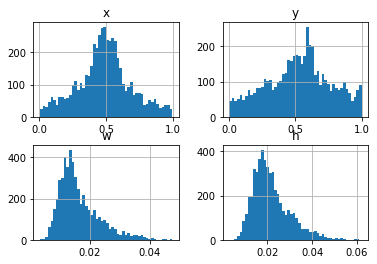

In [7]:
ladd_coords[['x','y','w','h']].hist(bins = 50)

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'h'}>]], dtype=object)

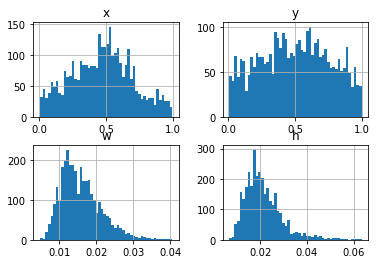

In [8]:
ipsar_coords[['x','y','w','h']].hist(bins = 50)